In [3]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def db(value):
    return 10*np.log10(value)

cuda


In [16]:
# Load the data
snr = 20

train_df = pd.read_csv(f'train_{snr}db.csv')
test_df = pd.read_csv(f'test_{snr}db.csv')

class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.labels = data.iloc[:, -1].values
        self.serises = data.iloc[:, :-1].values

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = db(self.serises[idx])
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.float32).to(device), torch.tensor(y, dtype=torch.long).to(device)

train_dataset = TimeSeriesDataset(train_df)
test_dataset = TimeSeriesDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

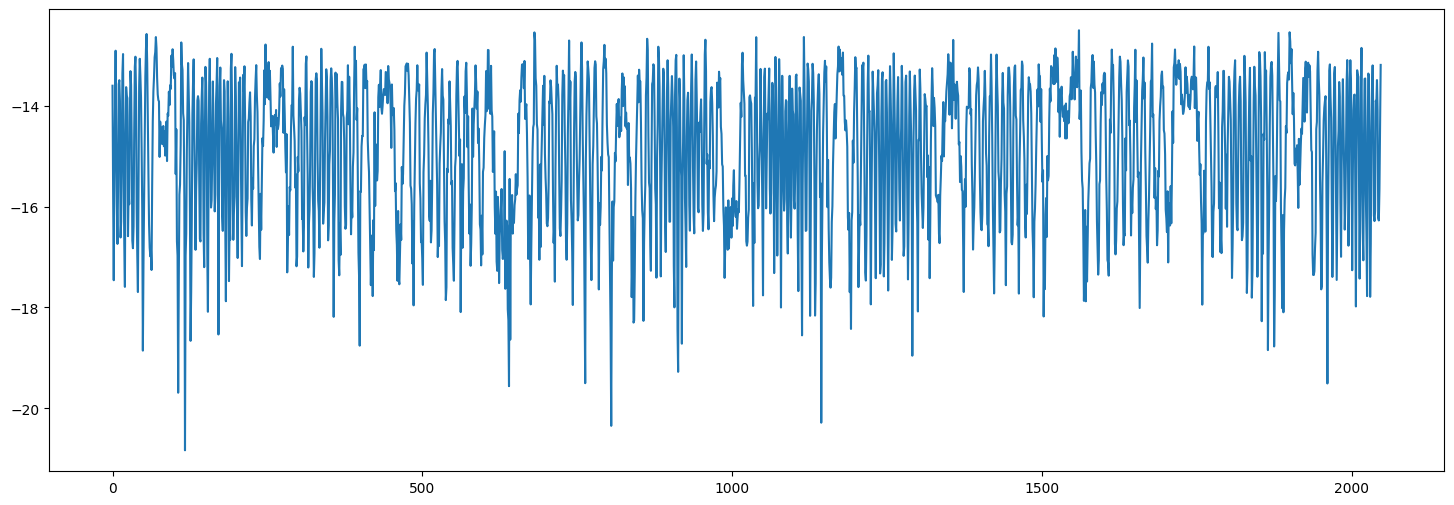

In [20]:
idx = 0
plt.figure(figsize = (18,6))
plt.plot(train_dataset.__getitem__(idx)[0].cpu().numpy());

In [21]:
for i, (b, l) in enumerate(train_loader):
    inputs = b
    print(inputs.size(), l.size())
    for step in inputs:
        print(step)
        break
    break

torch.Size([16, 2048]) torch.Size([16])
tensor([-13.8172, -13.9314, -13.0292,  ..., -12.9610, -14.2611, -14.0184],
       device='cuda:0')


In [41]:
# basic_linear_model
input_size = 2048
hidden_size = 1024

class Basic_Net(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Basic_Net,self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size,4)        
    
    def forward(self, x): 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)                   # No need to activate while using CrossEntropyLoss()
        return x

model = Basic_Net(input_size=input_size, hidden_size= hidden_size).to(device)

In [38]:
def train(dataloader, loss_fn, optimizer):
    total_acc, total_count, total_loss, = 0, 0, 0
    model.train()
    for series, label in dataloader:
        predicted_label = model(series)
        loss = loss_fn(predicted_label, label)
        # Back-propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            total_acc += (predicted_label.argmax(1) == label).sum().item()  # predict true
            total_count += label.size(0)
            total_loss += loss.item()*label.size(0)
    return total_loss/total_count, total_acc/total_count

def test(dataloader, loss_fn):
    model.eval()
    total_acc, total_count, total_loss, = 0, 0, 0

    with torch.no_grad():
        for series, label in dataloader:
            predicted_label = model(series)
            loss = loss_fn(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
            total_loss += loss.item()*label.size(0)
    return total_loss/total_count, total_acc/total_count

def fit(epochs, train_dl, test_dl, loss_fn, optimizer, exp_lr_scheduler):
    train_loss = [] 
    train_acc = []
    test_loss = []
    test_acc = []

    for epoch in range(epochs):
        
        epoch_loss, epoch_acc = train(train_dl, loss_fn, optimizer)
        epoch_test_loss, epoch_test_acc = test(test_dl, loss_fn)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)
        exp_lr_scheduler.step()
        template = ("epoch:{:2d}, train_loss: {:.5f}, train_acc: {:.1f}% ," 
                    "test_loss: {:.5f}, test_acc: {:.1f}%")
        if epoch%10 ==0:
            print(template.format(
                epoch, epoch_loss, epoch_acc*100, epoch_test_loss, epoch_test_acc*100))
    
    return train_loss, test_loss, train_acc, test_acc

In [39]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), betas=(0.5, 0.5), lr=0.001)
# betas=(0.5, 0.5) 一阶矩估计和二阶矩估计均为0.5
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
EPOCHS = 100
train_loss, test_loss, train_acc, test_acc = fit(EPOCHS, train_loader, test_loader, loss_fn, optimizer, exp_lr_scheduler)

epoch: 0, train_loss: 1.40181, train_acc: 25.1% ,test_loss: 1.37871, test_acc: 25.6%
epoch:10, train_loss: 1.38630, train_acc: 25.1% ,test_loss: 1.37914, test_acc: 25.6%
epoch:20, train_loss: 1.38736, train_acc: 25.5% ,test_loss: 1.37673, test_acc: 25.7%
epoch:30, train_loss: 1.38500, train_acc: 25.5% ,test_loss: 1.37670, test_acc: 25.7%
epoch:40, train_loss: 1.38514, train_acc: 25.3% ,test_loss: 1.37669, test_acc: 25.7%
epoch:50, train_loss: 1.38514, train_acc: 25.6% ,test_loss: 1.37669, test_acc: 25.7%
epoch:60, train_loss: 1.38512, train_acc: 25.6% ,test_loss: 1.37669, test_acc: 25.7%
epoch:70, train_loss: 1.38512, train_acc: 25.6% ,test_loss: 1.37669, test_acc: 25.7%
epoch:80, train_loss: 1.38512, train_acc: 25.6% ,test_loss: 1.37669, test_acc: 25.7%
epoch:90, train_loss: 1.38512, train_acc: 25.6% ,test_loss: 1.37669, test_acc: 25.7%
